In [2]:
# Imports and Setup

import numpy as np
import pandas as pd
import scipy as sp
from scipy.ndimage.filters import gaussian_filter as smooth

%matplotlib inline
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = 14, 10
plt.rcParams['lines.linewidth'] = 1.5

font = {'weight' : 'normal',
      'size'   : 15}

plt.rc('font', **font)

from fair_inverse_model import co2_conc_total as rf_to_conc
from fair_inverse_model import annual_emissions_calc2 as conc_to_emissions
from forward_multiple_GHG import fair_scm as FAIR_model
from forward_original import fair_scm as fair_carbon

In [3]:
#import emissions and RF data from file

datafile = 'RCP3PD'

emms_file = './RCPs/'+datafile+'_EMISSIONS.csv'
emms_data = np.genfromtxt(emms_file,skip_header=36,delimiter=',',names=True)

emissions = emms_data['FossilCO2'] + emms_data['OtherCO2']
M_emissions = emms_data['CH4']
N_emissions = emms_data['N2O'] * 44.0 / 28.0

forc_file = './RCPs/'+datafile+'_MIDYEAR_RADFORCING.csv'
forc_data = np.genfromtxt(forc_file,skip_header=58,delimiter=',',names=True)
other_rf = forc_data['TOTAL_ANTHRO_RF'] - forc_data['CO2_RF'] - forc_data['CH4_RF'] - forc_data['N2O_RF']

In [4]:
# Calculate the concs, temps, RFs and emissions (CO2-fe emissions)

C_0 = 278.0
y_0 = 1765

#total
out_total_diff_fair = FAIR_model(emissions=emissions,M_emissions=M_emissions,N_emissions=N_emissions,
                                other_rf=other_rf,N_0=270.0,MAGICC_model = True,
                                S_OH_CH4 = -0.32, S_T_CH4 = 0.035, tau_M_0 = 9.0)

#total minus CO2
out_co2_diff_fair = FAIR_model(M_emissions=M_emissions,N_emissions=N_emissions,
                                other_rf=other_rf,N_0=270.0,MAGICC_model = True,
                                S_OH_CH4 = -0.32, S_T_CH4 = 0.035, tau_M_0 = 9.0)

#total minus CH4
out_ch4_diff_fair = FAIR_model(emissions=emissions,N_emissions=N_emissions,
                                other_rf=other_rf,N_0=270.0,MAGICC_model = True,
                                S_OH_CH4 = -0.32, S_T_CH4 = 0.035, tau_M_0 = 9.0)

#total minus N2O
out_n2o_diff_fair = FAIR_model(emissions=emissions,M_emissions=M_emissions,
                                other_rf=other_rf,N_0=270.0,MAGICC_model = True,
                                S_OH_CH4 = -0.32, S_T_CH4 = 0.035, tau_M_0 = 9.0)

#total minus other
out_other_diff_fair = FAIR_model(emissions=emissions,M_emissions=M_emissions,N_emissions = N_emissions,
                                N_0=270.0,MAGICC_model = True,S_OH_CH4 = -0.32, 
                                S_T_CH4 = 0.035, tau_M_0 = 9.0)
        
#anthro total from RCP3 RF datafile    
out_anthro_0_diff_fair = FAIR_model(other_rf=forc_data['TOTAL_ANTHRO_RF'],
                              N_0=270.0,MAGICC_model = True,S_OH_CH4 = -0.32, 
                              S_T_CH4 = 0.035, tau_M_0 = 9.0)

# NB. the "0" signifier represents radiative forcings entirely NOT calculated by fair (ie. from RCP only)

#smoothing
ANTHRO_RF_0_diff_fair = smooth(out_anthro_0_diff_fair['forcing']['total'],5)
ANTHRO_RF_diff_fair = smooth(out_total_diff_fair['forcing']['total'],5)
anthro_minus_CH4_RF_diff_fair = smooth(out_ch4_diff_fair['forcing']['total'],5)
anthro_minus_N2O_RF_diff_fair = smooth(out_n2o_diff_fair['forcing']['total'],5)
anthro_minus_CO2_RF_diff_fair = smooth(out_co2_diff_fair['forcing']['total'],5)
anthro_minus_other_RF_diff_fair = smooth(out_other_diff_fair['forcing']['total'],5)

CH4_RF_diff_fair = ANTHRO_RF_diff_fair - anthro_minus_CH4_RF_diff_fair
N2O_RF_diff_fair = ANTHRO_RF_diff_fair - anthro_minus_N2O_RF_diff_fair
CO2_RF_diff_fair = ANTHRO_RF_diff_fair - anthro_minus_CO2_RF_diff_fair
other_RF_diff_fair = ANTHRO_RF_diff_fair - anthro_minus_other_RF_diff_fair

#concentrations
ANTHRO_conc_diff_fair = rf_to_conc(ANTHRO_RF_diff_fair)
anthro_minus_CH4_conc_diff_fair = rf_to_conc(anthro_minus_CH4_RF_diff_fair)
anthro_minus_CO2_conc_diff_fair = rf_to_conc(anthro_minus_CO2_RF_diff_fair)
anthro_minus_N2O_conc_diff_fair = rf_to_conc(anthro_minus_N2O_RF_diff_fair)
anthro_minus_other_conc_diff_fair = rf_to_conc(anthro_minus_other_RF_diff_fair)
ANTHRO_conc_0_diff_fair = rf_to_conc(ANTHRO_RF_0_diff_fair)

CH4_conc_diff_fair = ANTHRO_conc_diff_fair - anthro_minus_CH4_conc_diff_fair + C_0
N2O_conc_diff_fair = ANTHRO_conc_diff_fair - anthro_minus_N2O_conc_diff_fair + C_0
CO2_conc_diff_fair = ANTHRO_conc_diff_fair - anthro_minus_CO2_conc_diff_fair + C_0
other_conc_diff_fair = ANTHRO_conc_diff_fair - anthro_minus_other_conc_diff_fair + C_0

#co2-fe emissions
anthro_CO2_fe_emms_diff_fair = conc_to_emissions(ANTHRO_conc_diff_fair,out_total_diff_fair['temperature'],year_smoothing=0)* 44./12.
anthro_minus_CH4_diff_fair = conc_to_emissions(anthro_minus_CH4_conc_diff_fair,out_ch4_diff_fair['temperature'],year_smoothing=0)* 44./12.
anthro_minus_CO2_diff_fair = conc_to_emissions(anthro_minus_CO2_conc_diff_fair,out_co2_diff_fair['temperature'],year_smoothing=0)* 44./12.
anthro_minus_N2O_diff_fair = conc_to_emissions(anthro_minus_N2O_conc_diff_fair,out_n2o_diff_fair['temperature'],year_smoothing=0)* 44./12.
anthro_minus_other_diff_fair = conc_to_emissions(anthro_minus_other_conc_diff_fair,out_other_diff_fair['temperature'],year_smoothing=0)* 44./12.
anthro_CO2_fe_emms_0_diff_fair = conc_to_emissions(ANTHRO_conc_0_diff_fair,out_anthro_0_diff_fair['temperature'],year_smoothing=0)* 44./12.

CH4_CO2_fe_emms_diff_fair = anthro_CO2_fe_emms_diff_fair - anthro_minus_CH4_diff_fair
N2O_CO2_fe_emms_diff_fair = anthro_CO2_fe_emms_diff_fair - anthro_minus_N2O_diff_fair
CO2_CO2_fe_emms_diff_fair = anthro_CO2_fe_emms_diff_fair - anthro_minus_CO2_diff_fair
other_CO2_fe_emms_diff_fair = anthro_CO2_fe_emms_diff_fair - anthro_minus_other_diff_fair

#temperatures
T_total = out_total_diff_fair['temperature']
T_other = T_total - out_other_diff_fair['temperature']
T_co2 = T_total - out_co2_diff_fair['temperature']
T_ch4 = T_total - out_ch4_diff_fair['temperature']
T_n2o = T_total - out_n2o_diff_fair['temperature']
T_anthro_0 = out_anthro_0_diff_fair['temperature']


# Creating the dictionaries to then be nested within one output
emissions_diff_fair = {'CO2' : CO2_CO2_fe_emms_diff_fair, 'CH4' : CH4_CO2_fe_emms_diff_fair, 'N2O' : N2O_CO2_fe_emms_diff_fair, 
                              'other' : other_CO2_fe_emms_diff_fair, 'total' : anthro_CO2_fe_emms_diff_fair, 'anthro_0' : anthro_CO2_fe_emms_0_diff_fair}

concentration_diff_fair = {'CO2' : CO2_conc_diff_fair, 'CH4' : CH4_conc_diff_fair, 'N2O' : N2O_conc_diff_fair, 
                                  'other' : other_conc_diff_fair, 'total' : ANTHRO_conc_diff_fair, 'anthro_0' : ANTHRO_conc_0_diff_fair}
        
forcing_diff_fair = {'total' : ANTHRO_RF_diff_fair, 'other' : other_RF_diff_fair, 'CO2' : CO2_RF_diff_fair, 
                            'CH4' : CH4_RF_diff_fair, 'N2O' : N2O_RF_diff_fair, 'anthro_0' : ANTHRO_RF_0_diff_fair}
        
temperature_diff_fair = {'total' : T_total, 'other' : T_other, 'CO2' : T_co2, 
                                'CH4' : T_ch4, 'N2O' : T_n2o, 'anthro_0' : T_anthro_0}
        
# Nest again in the adding fair part
diff_fair = {'emissions' : emissions_diff_fair , 'concentration' : concentration_diff_fair , 'forcing' : forcing_diff_fair , 'temperature' : temperature_diff_fair}

In [5]:
#calculate emissions (GWP_100)

CO2_emissions_GWP100 = emissions * 44./12.
M_emissions_GWP100 = M_emissions * 34./1000.
N_emissions_GWP100 = N_emissions * 298./1000.

#smoothing
CO2_emissions_GWP100 = smooth(CO2_emissions_GWP100,5)
M_emissions_GWP100 = smooth(M_emissions_GWP100,5)
N_emissions_GWP100 = smooth(N_emissions_GWP100,5)

# should find a way to quantify other????

In [6]:
#recalculating temperatures from CO2-fe and GWP emissions using fair forward

C_CO2_GWP, T_CO2_GWP, RF_CO2_GWP = fair_carbon(emissions = CO2_emissions_GWP100 * 12./44.)
C_CH4_GWP, T_CH4_GWP, RF_CH4_GWP = fair_carbon(emissions = M_emissions_GWP100 * 12./44.)
C_N2O_GWP, T_N2O_GWP, RF_N2O_GWP = fair_carbon(emissions = N_emissions_GWP100 * 12./44.)

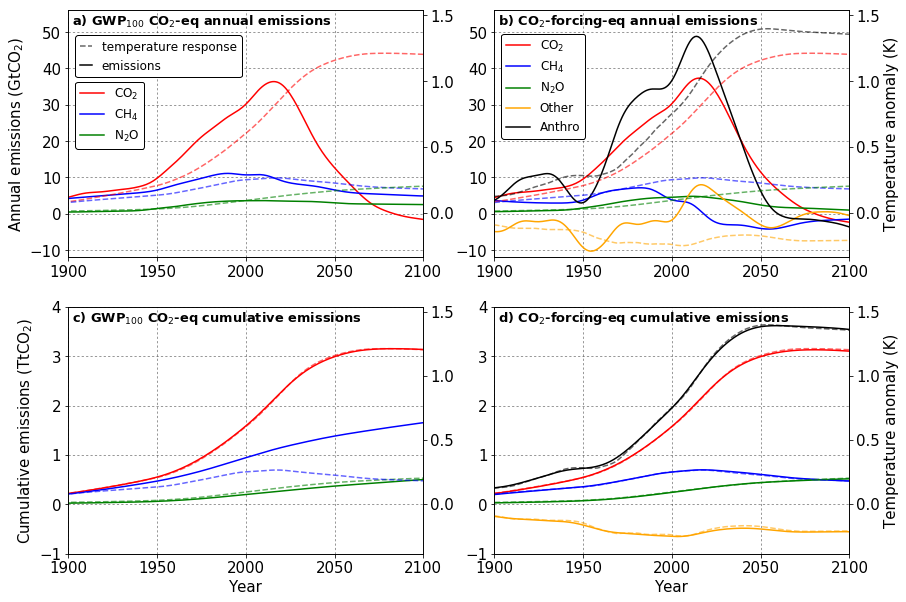

In [7]:
time = np.arange(y_0,y_0 + emissions.size)

fig = plt.figure()

ax1 = fig.add_subplot(222)
ax1.plot(time, diff_fair['emissions']['CO2'], color = 'red', label = 'CO$_2$')
ax1.plot(time, diff_fair['emissions']['CH4'], color = 'blue', label = 'CH$_4$')
ax1.plot(time, diff_fair['emissions']['N2O'], color = 'green', label = 'N$_2$O')
ax1.plot(time, diff_fair['emissions']['other'], color = 'orange', label = 'Other')
ax1.plot(time, diff_fair['emissions']['anthro_0'], color = 'black', label = 'Anthro')
ax1.set_xlim(1900,2100)
ax1.set_ylim(-12,56)
ax1.grid(True, linestyle = ':', color = 'black', alpha = 0.5)
ax1.legend(loc = (0.02,0.48), framealpha = 1, fontsize = 12, edgecolor = 'black')
ax1.text(1902,52, 'b) CO$_2$-forcing-eq annual emissions', fontweight = 'bold', fontsize = 13)

ax2 = fig.add_subplot(221)
ax2.plot(time, CO2_emissions_GWP100, color = 'red', label = 'CO$_2$')
ax2.plot(time, M_emissions_GWP100, color = 'blue', label = 'CH$_4$')
ax2.plot(time, N_emissions_GWP100, color = 'green', label = 'N$_2$O')
ax2.set_xlim(1900,2100)
ax2.set_ylim(-12,56)
ax2.grid(True, linestyle = ':', color = 'black', alpha = 0.5)
ax2.set_ylabel('Annual emissions (GtCO$_2$)')
ax2.legend(loc = (0.02,0.44), framealpha = 1, fontsize = 12, edgecolor = 'black')
ax2.text(1902,52, 'a) GWP$_{100}$ CO$_2$-eq annual emissions', fontweight = 'bold', fontsize = 13)

ax3 = fig.add_subplot(224)
ax3.plot(time, np.cumsum(diff_fair['emissions']['CO2'])/1000., color = 'red', label = 'CO$_2$')
ax3.plot(time, np.cumsum(diff_fair['emissions']['CH4'])/1000., color = 'blue', label = 'CH$_4$')
ax3.plot(time, np.cumsum(diff_fair['emissions']['N2O'])/1000., color = 'green', label = 'N$_2$O')
ax3.plot(time, np.cumsum(diff_fair['emissions']['other'])/1000., color = 'orange', label = 'Other')
ax3.plot(time, np.cumsum(diff_fair['emissions']['anthro_0'])/1000., color = 'black', label = 'Anthro')
ax3.set_xlim(1900,2100)
ax3.set_ylim(-1,4)
ax3.set_xlabel('Year')
ax3.grid(True, linestyle = ':', color = 'black', alpha = 0.5)
ax3.text(1902,3.7, 'd) CO$_2$-forcing-eq cumulative emissions', fontweight = 'bold', fontsize = 13)

ax4 = fig.add_subplot(223)
ax4.plot(time, np.cumsum(CO2_emissions_GWP100)/1000., color = 'red', label = 'CO$_2$')
ax4.plot(time, np.cumsum(M_emissions_GWP100)/1000., color = 'blue', label = 'CH$_4$')
ax4.plot(time, np.cumsum(N_emissions_GWP100)/1000., color = 'green', label = 'N$_2$O')
ax4.set_xlim(1900,2100)
ax4.set_ylim(-1,4)
ax4.grid(True, linestyle = ':', color = 'black', alpha = 0.5)
ax4.set_ylabel('Cumulative emissions (TtCO$_2$)')
ax4.set_xlabel('Year')
ax4.text(1902,3.7, 'c) GWP$_{100}$ CO$_2$-eq cumulative emissions', fontweight = 'bold', fontsize = 13)

ax5 = ax4.twinx()

##created to force legend to behave
#ax5.plot(time, np.ones(time.size)*45., '--', color='black', label = 'test2', alpha = 0.6)
#ax5.plot(time, np.ones(time.size)*40., color = 'black', label = 'test')
#actual lines to plot
ax5.plot(time, T_co2, '--', color='red', label = 'CO$_2$', alpha = 0.6, linewidth = 1.5)
ax5.plot(time, T_n2o, '--', color='green', label = 'N$_2$O', alpha = 0.6, linewidth = 1.5)
ax5.plot(time, T_ch4, '--', color='blue', label = 'CH$_4$', alpha = 0.6, linewidth = 1.5)
#ax5.plot(time, T_other, '--', color='orange', label = 'Other')
#ax5.plot(time, T_anthro_0, '--', color='black', label = 'Anthro')
ax5.set_ylim(-0.39,1.54)
ax5.set_xlim(1900,2100)

#ax5.legend(["temperature response", "cumulative CO$_2$-fe emissions"], handlelength=1, loc = (0.02, 0.69), framealpha = 1, edgecolor = 'black', fontsize = 12)
#handles, labels = ax5.get_legend_handles_labels()
#line0 = handles[0]
#handles[0] = line0
#line1 = handles[1]
#line1.set_linestyle('-')
#handles[1] = line1
#labels = ["temperature response", "cumulative CO$_2$-fe emissions"]
#ax5.legend(handles, labels, handlelength=1, loc = (0.02, 0.67), framealpha = 1, edgecolor = 'black', fontsize = 12)

ax6 = ax3.twinx()
ax6.plot(time, T_co2, '--', color='red', label = 'CO$_2$', alpha = 0.6, linewidth = 1.5)
ax6.plot(time, T_ch4, '--', color='blue', label = 'CH$_4$', alpha = 0.6, linewidth = 1.5)
ax6.plot(time, T_n2o, '--', color='green', label = 'N$_2$O', alpha = 0.6, linewidth = 1.5)
ax6.plot(time, T_other, '--', color='orange', label = 'Other', alpha = 0.6, linewidth = 1.5)
ax6.plot(time, T_anthro_0, '--', color='black', label = 'Anthro', alpha = 0.6, linewidth = 1.5)
ax6.set_ylabel('Temperature anomaly (K)')
ax6.set_ylim(-0.39,1.54)
ax6.set_xlim(1900,2100)

ticks = [0.0,0.5,1.0,1.5]
ax5.yaxis.set_ticks(ticks)
ax6.yaxis.set_ticks(ticks)

ax7 = ax1.twinx()
ax7.plot(time, T_co2, '--', color='red', label = 'CO$_2$', alpha = 0.6, linewidth = 1.5)
ax7.plot(time, T_ch4, '--', color='blue', label = 'CH$_4$', alpha = 0.6, linewidth = 1.5)
ax7.plot(time, T_n2o, '--', color='green', label = 'N$_2$O', alpha = 0.6, linewidth = 1.5)
ax7.plot(time, T_other, '--', color='orange', label = 'Other', alpha = 0.6, linewidth = 1.5)
ax7.plot(time, T_anthro_0, '--', color='black', label = 'Anthro', alpha = 0.6, linewidth = 1.5)
ax7.set_ylabel('Temperature anomaly (K)')
ax7.set_ylim(-0.34,1.54)
ax7.set_xlim(1900,2100)
ax7.yaxis.set_ticks(ticks)

ax8 = ax2.twinx()
ax8.plot(time, np.ones(time.size)*30., '--', color='black', label = 'test2', alpha = 0.6)
ax8.plot(time, np.ones(time.size)*30., color = 'black', label = 'test')

ax8.plot(time, T_co2, '--', color='red', label = 'CO$_2$', alpha = 0.6, linewidth = 1.5)
ax8.plot(time, T_ch4, '--', color='blue', label = 'CH$_4$', alpha = 0.6, linewidth = 1.5)
ax8.plot(time, T_n2o, '--', color='green', label = 'N$_2$O', alpha = 0.6, linewidth = 1.5)
#ax8.plot(time, T_other, '--', color='orange', label = 'Other', alpha = 0.6, linewidth = 1.5)
#ax8.plot(time, T_anthro_0, '--', color='black', label = 'Anthro', alpha = 0.6, linewidth = 1.5)
ax8.set_ylim(-0.34,1.54)
ax8.set_xlim(1900,2100)
ax8.yaxis.set_ticks(ticks)

ax8.legend(["temperature response", "cumulative CO$_2$-fe emissions"], handlelength=1, loc = (0.02, 0.69), framealpha = 1, edgecolor = 'black', fontsize = 12)
handles, labels = ax8.get_legend_handles_labels()
line0 = handles[0]
handles[0] = line0
line1 = handles[1]
line1.set_linestyle('-')
handles[1] = line1
labels = ["temperature response", "emissions"]
ax8.legend(handles, labels, handlelength=1, loc = (0.02, 0.73), framealpha = 1, edgecolor = 'black', fontsize = 12)

#fig.savefig('MAIN FIGURE TEST 2', dpi = 600)


KEY POINTS:

- FAIR standard parameters
- Differenced CO$_2$-fe emissions
- Differenced temperatures for plots (FROM NICKS CODE OUTPUT)
- Temperature profiles are (trivially) exactly the shape of CO$_2$-fe cumulative emissions
- CO$_2$-fe emissions are a much clearer and more exact way to specify the contribution to global average temperature anomaly, because of this relationship between a gases CO$_2$-fe emissions profile and its contribution to global temperature anomaly
- Temperature contributions checked with fair forward and CO$_2$-fe emissions profiles
- Differences between CO$_2$ line in two top plots is just a result of non-linearities (highlighted because of differencing in the CO$_2$-fe method). Same for differences between temperature lines and cumulative CO$_2$ on bottom RH axes.


QUESTIONS:

- Do we actually want to plot temperature curves on cumulative graphs since the relationship is so exact, or just have one set of lines?
- Do we have temperature lines on top plots, if so how do we stop cluttering of all the lines? (inlay temp plot???)
- Do we find a way to represent other emissions on the GWP$_{100}$ graphs so we have a way of getting all lines on there? (If we do represent other, Anthro becomes sum of all lines). I.e. how should I represent other on left hand plots?
- Should we be using MAGICC derived parameters since we are using RCP3PD data?


TO DO:

- Temperatures need to be set relative to 1850-1879?
- Email Zeb back
- Email Myles to see what he says about our differences

(1900, 2100)

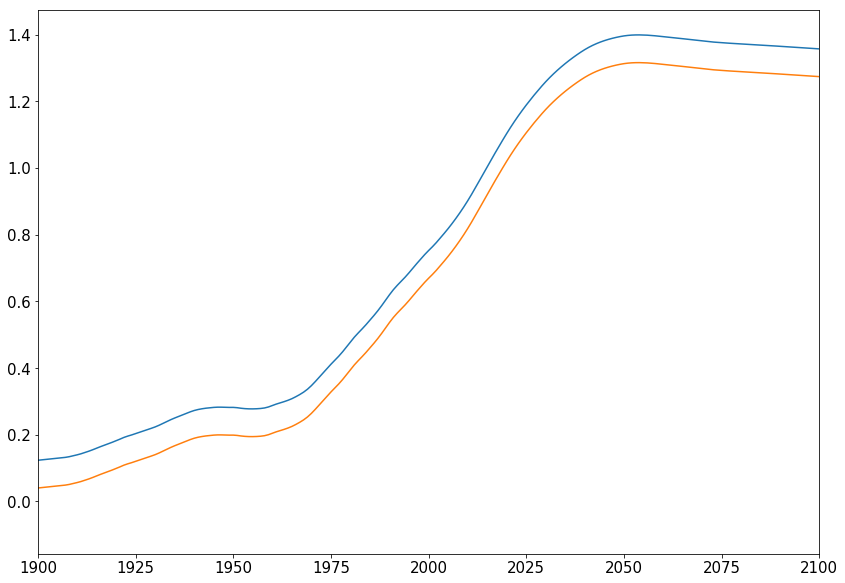

In [8]:
# Temperature profile adjusted for average 1850-1879 temperatures

plt.plot(time, T_anthro_0)

T_av = np.sum(T_anthro_0[1850-y_0:1879-y_0])/len(T_anthro_0[1850-y_0:1879-y_0])
plt.plot(time, T_anthro_0-T_av)
plt.xlim(1900,2100)